https://www.iue.tuwien.ac.at/phd/singulani/dissch3.html


$$
\frac{d^2 u}{dx^2} =f(x),
0<x<1
\\
u(0) = u(1) = 0
\\
f(x) = 1+\delta(x-0.5)
$$


In [160]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy.solvers import ode

Analytical solution


In [161]:
x = sp.symbols('x')  # symbol
u = sp.Function('u')  # symbolic function
func = 1 + sp.DiracDelta(x-0.5)
eqn = u(x).diff(x).diff(x) - func  # = 0
eqn

-DiracDelta(x - 0.5) + Derivative(u(x), (x, 2)) - 1

In [162]:
ode.classify_ode(eqn)

('nth_algebraic',
 'nth_linear_constant_coeff_variation_of_parameters',
 'nth_linear_euler_eq_nonhomogeneous_variation_of_parameters',
 'nth_algebraic_Integral',
 'nth_linear_constant_coeff_variation_of_parameters_Integral',
 'nth_linear_euler_eq_nonhomogeneous_variation_of_parameters_Integral')

In [163]:
sympy_sol = ode.dsolve(eqn, ics={u(0): 0, u(1): 0})
expr = sympy_sol.rhs
u0_sympy_sol = sp.lambdify(x, expr, 'numpy')
sympy_sol

Eq(u(x), x**2/2 + x*(Heaviside(x - 0.5) - 1) - 0.5*Heaviside(x - 0.5))

Numerical Solution


In [164]:
xmin = 0
xmax = 1
hx = 0.01

nx = int((xmax - xmin) / hx) + 1
x_array, hx = np.linspace(xmin, xmax, nx, retstep=True)
nx = len(x_array)
nx

101

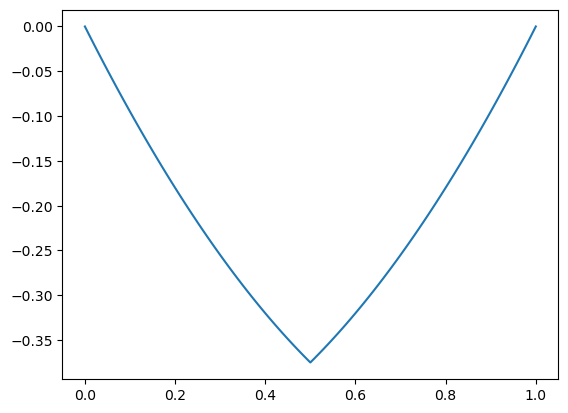

In [165]:
plt.plot(x_array, u0_sympy_sol(x_array))

In [166]:
def errors(true_values, test_values):
    mse = np.average((true_values - test_values)**2)
    mae = np.average(np.abs(true_values - test_values))
    mx = np.max(np.abs(true_values - test_values))
    print(f"MSE: {mse:.2e}, MAE: {mae:.2e}, MAX: {mx:.2e}")


def tester(x_points, solution_points, test_points, label):
    plt.figure(figsize=(17, 8))
    plt.plot(x_points, solution_points, label='exact sol')
    plt.plot(x_points, test_points, label=label)
    plt.legend()
    plt.ylabel('u')
    plt.xlabel('x')
    plt.grid()

    errors(solution_points, test_points)


x = sp.var('x')
f = 1 + sp.DiracDelta(x-0.5)


def solution(x):
    return u0_sympy_sol(x)


def value_v_k(k):
    def v_k(x):
        return np.piecewise(x, [x_array[k-1] <= x <= x_array[k], x_array[k] < x <= x_array[k+1], x < x_array[k-1] or x > x_array[k+1]],
                            [lambda x: (x - x_array[k-1])/(x_array[k] - x_array[k-1]),
                             lambda x: (x_array[k+1] - x) /
                             (x_array[k+1] - x_array[k]),
                             lambda x: 0])
    return v_k


def value_v_k_sympy(k):
    x = sp.symbols('x')
    conditions = [(sp.Rational(x_array[k-1]) <= x) & (x <= sp.Rational(x_array[k])),
                  (sp.Rational(x_array[k]) < x) & (
                      x <= sp.Rational(x_array[k+1])),
                  (x < sp.Rational(x_array[k-1])) | (x > sp.Rational(x_array[k+1]))]
    pieces = [(x - sp.Rational(x_array[k-1]))/(sp.Rational(x_array[k]) - sp.Rational(x_array[k-1])),
              (sp.Rational(x_array[k+1]) - x) /
              (sp.Rational(x_array[k+1]) - sp.Rational(x_array[k])),
              0]
    v_k = sp.Piecewise((pieces[0], conditions[0]),
                       (pieces[1], conditions[1]),
                       (pieces[2], conditions[2]))
    return v_k


def matrix_phi():
    phi = []
    for i in range(1, nx-1):
        phi.append([])
        for j in range(1, nx-1):
            if i == j:
                data = 2/hx
            elif (i == j + 1) or (i == j - 1):
                data = -1/hx
            else:
                data = 0
            phi[i-1].append(data)
    phi = np.array(phi)
    return phi


# def vector_b():
#     b = []
#     for i in range(1, nx):
#         data = (f.subs({x_: x_array[i]})).evalf() * hx
#         b.append(data)
#     b = np.array(b)
#     return b

def vector_b():
    b = []
    for i in range(1, nx-1):
        basis_ = value_v_k_sympy(i)
        data = sp.integrate(f*basis_, (x, x_array[i]-hx, x_array[i]+hx))
        b.append(data)
    b = np.array(b)
    return b


def sweep(a, b, c, f, n):
    alpha = np.array([0.0] * (n + 1))
    beta = np.array([0.0] * (n + 1))
    for i in range(n):
        alpha[i + 1] = -c[i] / (a[i] * alpha[i] + b[i])
        beta[i + 1] = (f[i] - a[i] * beta[i]) / (a[i] * alpha[i] + b[i])
    x = np.array([0.0] * n)
    x[n - 1] = beta[n]
    for i in range(n - 2, -1, -1):
        x[i] = alpha[i + 1] * x[i + 1] + beta[i + 1]
    return x


def forward(A, B, C, D, n):
    A_ = [-C[0] / B[0]]
    B_ = [D[0] / B[0]]
    for i in range(1, n):
        A_.append(- C[i] / (B[i] + A[i] * A_[i-1]))
        B_.append((D[i] - A[i]*B_[i-1]) / (B[i] + A[i] * A_[i-1]))
    return A_, B_


def backward(A, B, n):
    Y = []
    Y.append(B[n-1])
    for i in range(n - 2, -1, -1):
        Y.append(B[i] + A[i] * Y[n - i - 2])
    return Y[::-1]


def finite_element_method():
    phi = matrix_phi()
    b = vector_b()

    B = phi.diagonal()
    N = len(B)

    A = np.zeros(shape=(N,))
    C = np.zeros(shape=(N,))
    A[1:] = phi.diagonal(-1)
    C[:-1] = phi.diagonal(+1)
    D = ((-1)*b)

    A_, B_ = forward(A, B, C, D, N)
    u = backward(A_, B_, N)
    # u = sweep(A, B, C, D, N)
    return u.copy()

In [167]:
phi = matrix_phi()
b = vector_b()

B = phi.diagonal()
N = len(B)

A = np.zeros(shape=(N,))
C = np.zeros(shape=(N,))
A[1:] = phi.diagonal(-1)
C[:-1] = phi.diagonal(+1)
D = ((-1)*b)

A_, B_ = forward(A, B, C, D, N)
u = backward(A_, B_, N)

In [168]:
b

array([5764607523034235/576460752303423488,
       11529215046068469/1152921504606846976,
       5764607523034235/576460752303423488,
       1441151880758559/144115188075855872,
       2882303761517117/288230376151711744, 0.0100000000000000,
       0.0100000000000000, 720575940379279/72057594037927936,
       0.00999999999999989, 0.00999999999999995,
       720575940379279/72057594037927936,
       1441151880758559/144115188075855872, 0.0100000000000000,
       720575940379279/72057594037927936,
       720575940379279/72057594037927936, 45035996273705/4503599627370496,
       720575940379279/72057594037927936,
       720575940379279/72057594037927936, 45035996273705/4503599627370496,
       720575940379279/72057594037927936,
       720575940379279/72057594037927936, 45035996273705/4503599627370496,
       720575940379279/72057594037927936,
       720575940379279/72057594037927936, 45035996273705/4503599627370496,
       45035996273705/4503599627370496, 45035996273705/4503599627370496,


In [169]:
u_element = finite_element_method()

In [170]:
basis_ = [value_v_k(k) for k in range(1, nx-1)]
basis_ = np.array(basis_)


def sum(x):
    data = 0
    for i in range(len(basis_)):
        data += u_element[i] * basis_[i](x)
    return data


vectorize = np.vectorize(sum)
numerical_solution1 = vectorize(x_array)
analytical_solution = solution(x_array)
analytical_solution

array([ 0.     , -0.00995, -0.0198 , -0.02955, -0.0392 , -0.04875,
       -0.0582 , -0.06755, -0.0768 , -0.08595, -0.095  , -0.10395,
       -0.1128 , -0.12155, -0.1302 , -0.13875, -0.1472 , -0.15555,
       -0.1638 , -0.17195, -0.18   , -0.18795, -0.1958 , -0.20355,
       -0.2112 , -0.21875, -0.2262 , -0.23355, -0.2408 , -0.24795,
       -0.255  , -0.26195, -0.2688 , -0.27555, -0.2822 , -0.28875,
       -0.2952 , -0.30155, -0.3078 , -0.31395, -0.32   , -0.32595,
       -0.3318 , -0.33755, -0.3432 , -0.34875, -0.3542 , -0.35955,
       -0.3648 , -0.36995, -0.375  , -0.36995, -0.3648 , -0.35955,
       -0.3542 , -0.34875, -0.3432 , -0.33755, -0.3318 , -0.32595,
       -0.32   , -0.31395, -0.3078 , -0.30155, -0.2952 , -0.28875,
       -0.2822 , -0.27555, -0.2688 , -0.26195, -0.255  , -0.24795,
       -0.2408 , -0.23355, -0.2262 , -0.21875, -0.2112 , -0.20355,
       -0.1958 , -0.18795, -0.18   , -0.17195, -0.1638 , -0.15555,
       -0.1472 , -0.13875, -0.1302 , -0.12155, -0.1128 , -0.10

MSE: 4.09e-29, MAE: 5.50e-15, MAX: 9.96e-15


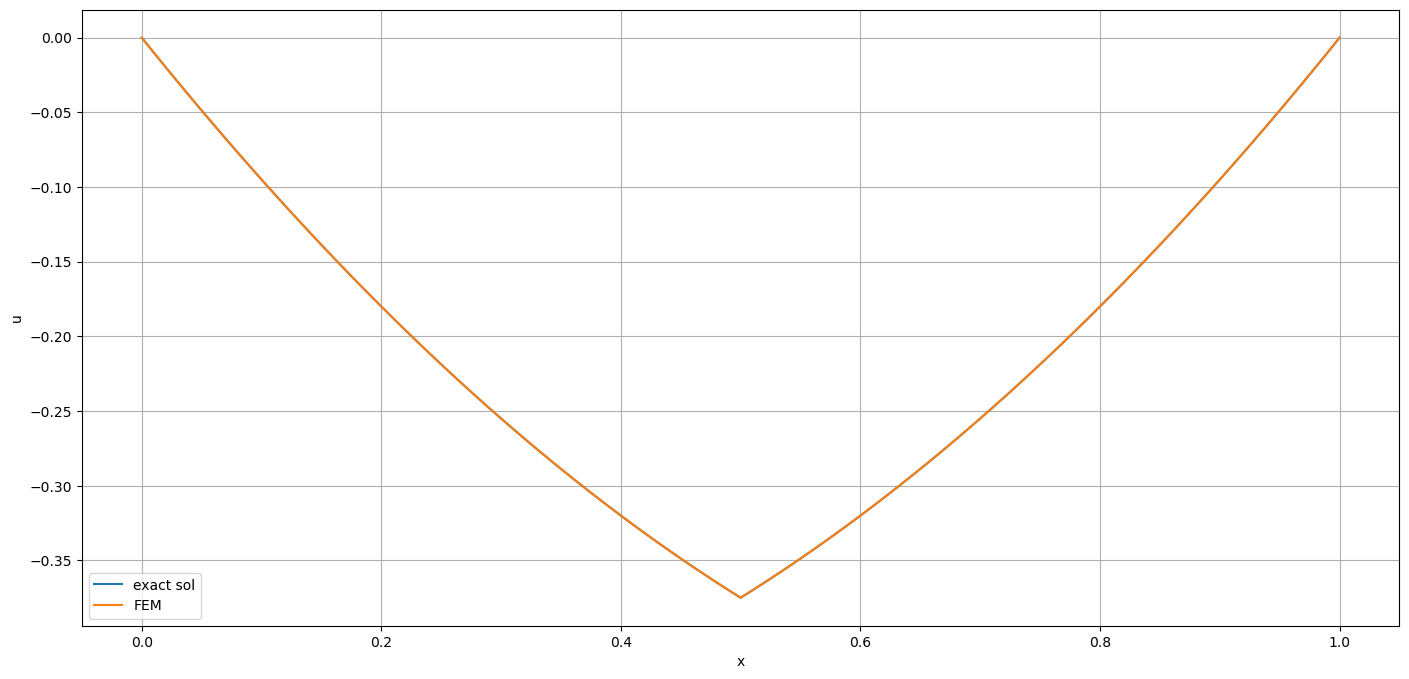

In [171]:
tester(x_array, analytical_solution, numerical_solution1, 'FEM')